## Код выполняет анализ и классификацию сетевого трафика на предмет наличия в нем вредоносной активности. 

In [1]:
# Импорт необходимых библиотек
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## # Чтение и обработка набора данных

In [3]:
dataset_root = 'datasets/nsl-kdd'

In [4]:
train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

In [5]:
# Исходные названия признаков набора данных KDD

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

In [6]:
# Индексы номинальных, бинарных и числовых признаков

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

# Создание списков номинальных, бинарных и числовых признаков
nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [7]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open('datasets/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attac)

# Создание отображения атак на категории
attack_mapping = dict((v,k) for k in category for v in category[k])

##  Генерация и анализ наборов данных обучения и тестирования. Подсчитывается количество каждого типа атаки в обучающем наборе данных и визуализируется распределение атак по их категориям.

In [8]:
train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)
    
test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

## Визуализация атак в обучающем наборе

In [9]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

In [10]:
test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

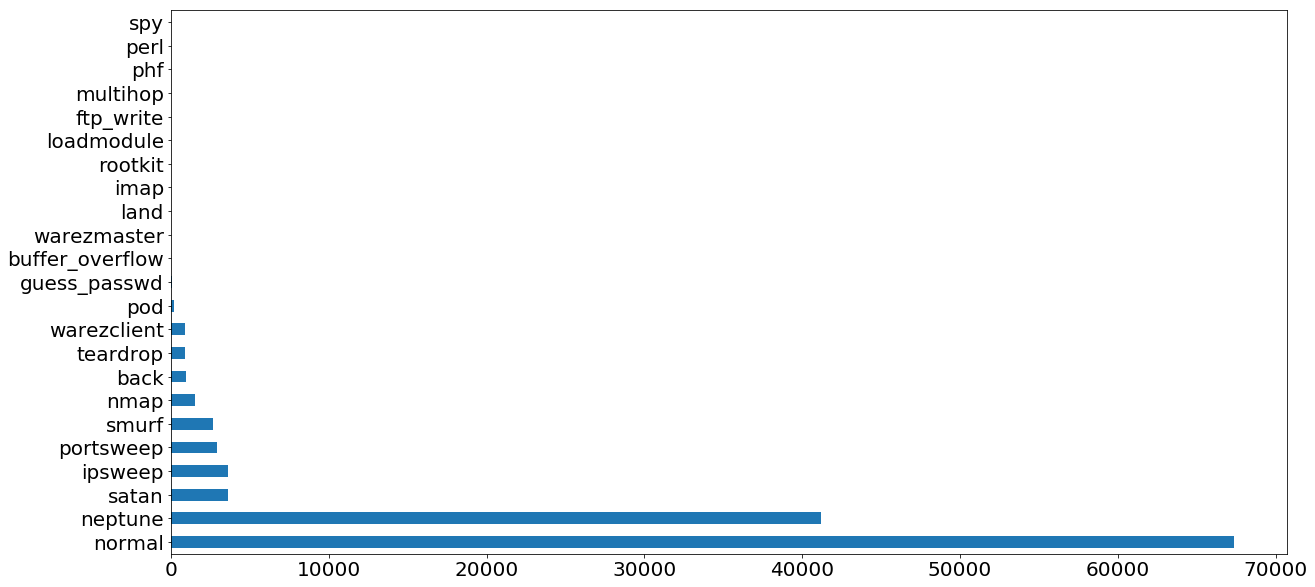

In [11]:
train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

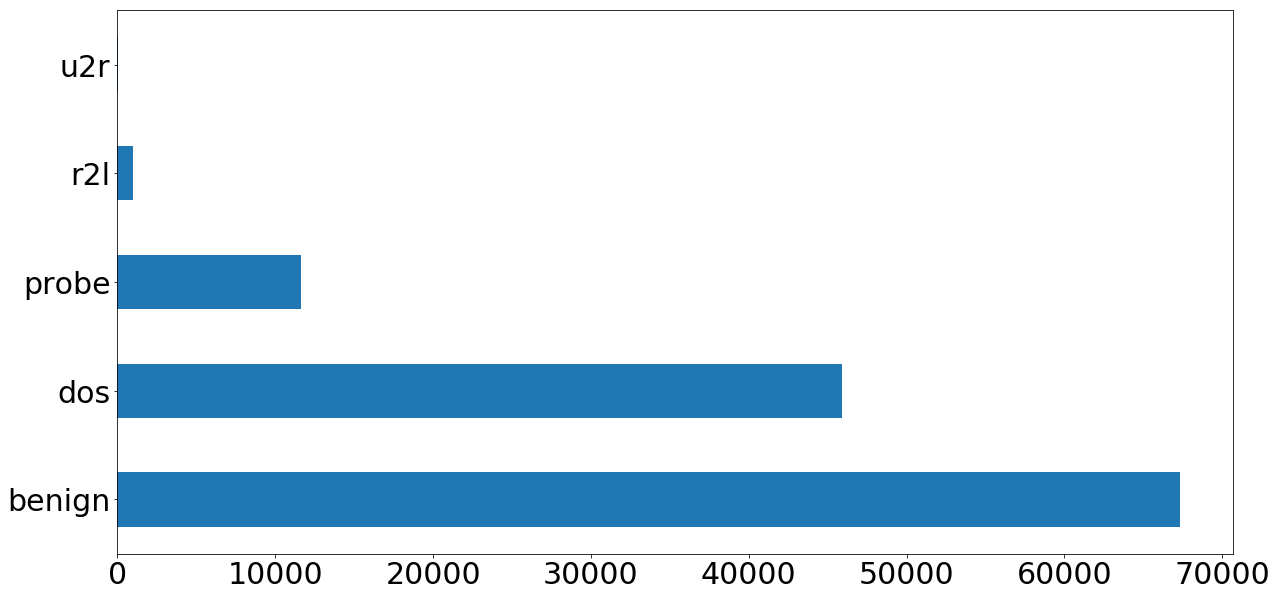

In [12]:
train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

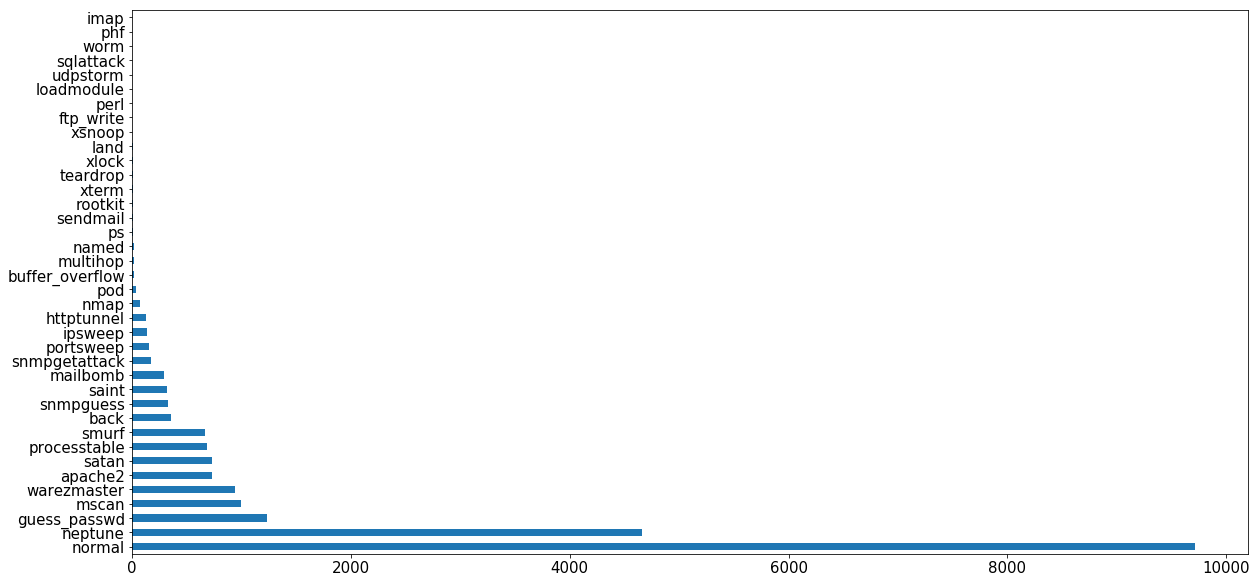

In [13]:
test_attack_types.plot(kind='barh', figsize=(20,10), fontsize=15)

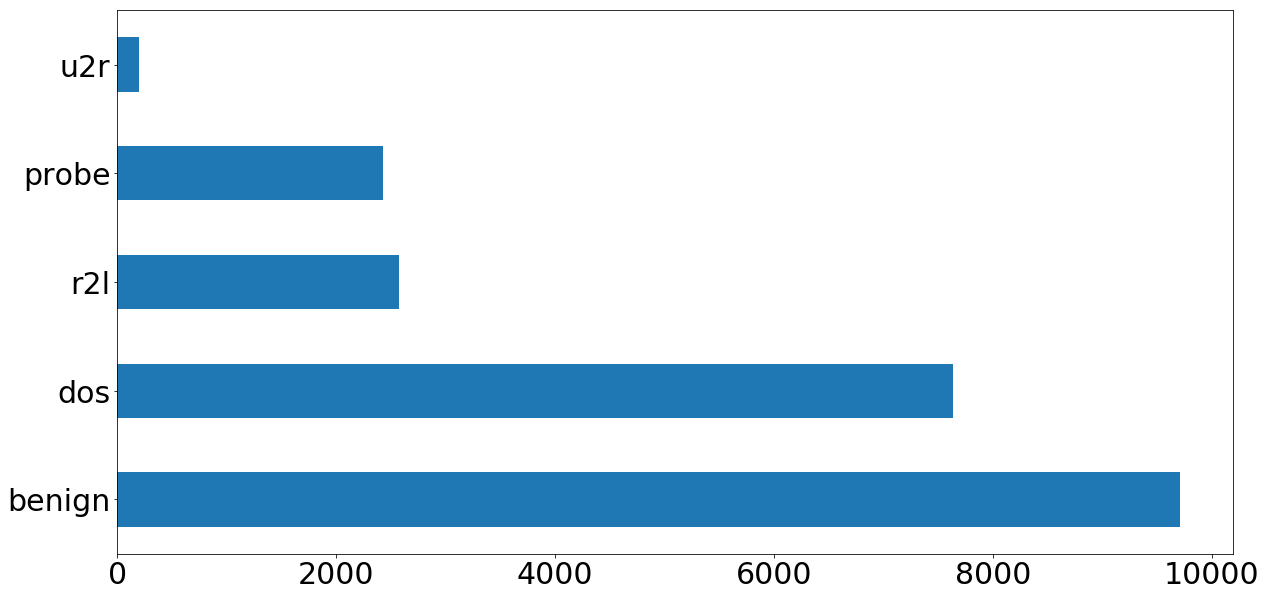

In [14]:
test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

In [15]:
# Давайте взглянем на бинарные функции
# По определению, все эти функции должны иметь минимальное значение 0.0 и максимальное значение 1.0.0 and a max of 1.0

train_df[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,125973.0,0.000198,0.014086,0.0,0.0,0.0,0.0,1.0
logged_in,125973.0,0.395736,0.489010,0.0,0.0,0.0,1.0,1.0
root_shell,125973.0,0.001342,0.036603,0.0,0.0,0.0,0.0,1.0
su_attempted,125973.0,0.001103,0.045154,0.0,0.0,0.0,0.0,2.0
is_host_login,125973.0,0.000008,0.002817,0.0,0.0,0.0,0.0,1.0
is_guest_login,125973.0,0.009423,0.096612,0.0,0.0,0.0,0.0,1.0


## Проверка бинарных признаков и обработка значений столбца 'su_attempted': Проверяются бинарные признаки на наличие аномальных значений, а также столбец 'su_attempted' исправляется, чтобы он содержал только значения 0 и 1.

In [16]:
# Подождите минутку... столбец su_attempted имеет максимальное значение 2.0?
train_df.groupby(['su_attempted']).size()

su_attempted
0    125893
1        21
2        59
dtype: int64

In [17]:
# Обработка значений столбца 'su_attempted'

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

su_attempted
0    125952
1        21
dtype: int64

## Удаление столбца 'num_outbound_cmds': Этот столбец удаляется, так как он не содержит полезной информации для классификации.

In [18]:
# Далее мы замечаем, что столбец num_outbound_cmds принимает только одно значение!

train_df.groupby(['num_outbound_cmds']).size()

num_outbound_cmds
0    125973
dtype: int64

In [19]:
#Удаление столбца 'num_outbound_cmds'

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

## Подготовка данных.  Данные обучения и тестирования преобразуются в формат, пригодный для обучения моделей машинного обучения. Категориальные признаки кодируются с использованием метода One-Hot Encoding, а числовые признаки масштабируются для лучшей работы алгоритмов.

In [20]:
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)

In [21]:
combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Хранить фиктивные имена переменных объектов
dummy_variables = list(set(train_x)-set(combined_df_raw))

In [22]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.00000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,0.08917,0.012399,0.000818,0.019218,0.276655,0.002897,0.001008,0.000389,0.594929,0.002151
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,0.28499,0.110661,0.028583,0.137292,0.447346,0.053750,0.031736,0.019719,0.490908,0.046332
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
# Пример статистики для функции "длительность" перед масштабированием
train_x['duration'].describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
Name: duration, dtype: float64

In [24]:
# Экспериментирование со стандартным масштабированием для единственной функции "длительность"
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count    1.259730e+05
mean     2.549477e-17
std      1.000004e+00
min     -1.102492e-01
25%     -1.102492e-01
50%     -1.102492e-01
75%     -1.102492e-01
max      1.636428e+01
dtype: float64

In [25]:
# Экспериментируем с MinMaxScaler над единственной функцией "длительность"
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

count    125973.000000
mean          0.006692
std           0.060700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [26]:
# Экспериментируем с RobustScaler над единственной функцией "длительность"
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
dtype: float64

In [27]:
# Давайте продолжим с помощью StandardScaler- применим ко всем числовым столбцам

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

In [28]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,...,125973.00000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,2.549477e-17,-4.512349e-19,7.614590e-19,0.000198,4.230328e-19,4.455945e-18,-2.244894e-17,2.989431e-18,0.395736,-6.549957e-18,...,0.08917,0.012399,0.000818,0.019218,0.276655,0.002897,0.001008,0.000389,0.594929,0.002151
std,1.000004e+00,1.000004e+00,1.000004e+00,0.014086,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.489010,1.000004e+00,...,0.28499,0.110661,0.028583,0.137292,0.447346,0.053750,0.031736,0.019719,0.490908,0.046332
min,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.102492e-01,-7.754745e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,-1.102492e-01,-7.715224e-03,-4.790326e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,1.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.636428e+01,2.350675e+02,3.257486e+02,1.000000,1.174348e+01,2.088191e+02,3.571955e+01,1.104972e+02,1.000000,3.123689e+02,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

## Производится классификация данных с использованием различных алгоритмов машинного обучения, таких как решающее дерево, k-ближайших соседей и линейный SVM.

In [30]:
# 5-версия классификации класса
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss

classifier = DecisionTreeClassifier(random_state=17)
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)

[[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 675  220 1528    0    0]
 [2278    1   14  277    4]
 [ 179    0    5    5   11]]
0.237979063165


## benign = 0, dos = 1, probe = 2, r2l = 3, u2r = 4.)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)

[[9457   57  193    2    2]
 [1675 5894   67    0    0]
 [ 670  156 1597    0    0]
 [2369    2   37  126   40]
 [ 176    0    4    7   13]]
0.242059971611


In [32]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)

[[9008  292  407    3    1]
 [1972 5654   10    0    0]
 [ 718  122 1496   87    0]
 [2472    2    1   99    0]
 [ 181    2    0    4   13]]
0.278300212917


## Борьба с классовым дисбалансом. Применяются методы oversampling (SMOTE) и undersampling (RandomUnderSampler) для борьбы с дисбалансом классов в данных.

In [33]:
test_Y.value_counts().apply(lambda x: x/float(len(test_Y)))

benign    0.430758
dos       0.338715
r2l       0.114177
probe     0.107479
u2r       0.008872
Name: attack_category, dtype: float64

In [34]:
train_Y.value_counts().apply(lambda x: x/float(len(train_Y)))

benign    0.534583
dos       0.364578
probe     0.092528
r2l       0.007899
u2r       0.000413
Name: attack_category, dtype: float64

In [35]:
print(pd.Series(train_Y).value_counts())

benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: attack_category, dtype: int64


## SMOTE (Synthetic Minority Over-sampling Technique). Оверсэмплинг - это метод, при котором количество экземпляров в меньшем классе увеличивается путем создания синтетических экземпляров, чтобы достичь баланса классов.

In [36]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(ratio='auto', random_state=0)
train_x_sm, train_Y_sm = sm.fit_sample(train_x, train_Y)
print(pd.Series(train_Y_sm).value_counts())

u2r       67343
dos       67343
probe     67343
r2l       67343
benign    67343
dtype: int64


## Этот код выполняет недосэмплинг (undersampling) обучающего набора данных с использованием метода RandomUnderSampler. Недосэмплинг - это метод, при котором количество экземпляров в большем классе уменьшается до заданного уровня, чтобы достичь баланса классов.

In [37]:
from imblearn.under_sampling import RandomUnderSampler

mean_class_size = int(pd.Series(train_Y).value_counts().sum()/5)

ratio = {'benign': mean_class_size,
         'dos': mean_class_size,
         'probe': mean_class_size,
         'r2l': mean_class_size,
         'u2r': mean_class_size}

rus = RandomUnderSampler(ratio=ratio, random_state=0, replacement=True)
train_x_rus, train_Y_rus = rus.fit_sample(train_x_sm, train_Y_sm)
print(pd.Series(train_Y_rus).value_counts())

u2r       25194
dos       25194
benign    25194
r2l       25194
probe     25194
dtype: int64


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss

classifier = DecisionTreeClassifier(random_state=17)
classifier.fit(train_x_rus, train_Y_rus)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)

[[9369   73  258    6    5]
 [1221 5768  647    0    0]
 [ 270  170 1980    1    2]
 [1829    2  369  369    5]
 [  62    0  108   21    9]]
0.223962029808
